# Calculating attenuation for a standard linear solid with `deformation_models` and `pyleoclim`

In this notebook, we'll take the second example from the previous notebook a standard linear solid (SLS) under oscillatory load and actually calculate the phase plag. For that calculation, we'll use the `pyleoclim` package. While a bit over-powered for our case here, `pyleoclim` provides convenient access to nice plotting interfaces and time series analysis functions (for our case here, wavelet coherence). 

So let's start by importing our packages and defining the same stress-strain calculations as the previous notebook

In [1]:
from __future__ import annotations

import matplotlib.pyplot as plt
import numpy as np
from pyleoclim import MultipleSeries, Series

from deformation_models import SLS

In [2]:
def stress_steps(tstar, stress_func):
    stress_dot_t = stress_func(tstar)
    return stress_dot_t[1:] - stress_dot_t[:-1]


def J_signal(solid, t, tstar):
    t_diff = t - tstar
    return solid.J_t(t_diff)[0:-1]


def calc_stress_strain(tmax, dt_max, stress_func, solid, tmin=0.001, n_t=1000):
    """
    calculate strain evolution for an applied-stress stress function

    Parameters
    ----------
    tmax: the max time to calculate for
    dt_max: the max allowed timestep when convolving stress with creep function
    stress_func: the function to use for calculating stress at a given time
    solid: the deformation_model solid instance to calculate strain for
    tmin: the starting time (default 0.001)
    n_t: number of timesteps

    Returns
    -------
    tuple
        a 3-element tuple of np arrays: (strain_vals, stress_vals, t_actual)
        strain_vals: the accumulated strain at every time step
        stress_vals: the applied stress at every time step
        t_actual: the time at every timestep

    """
    t_actual = np.linspace(tmin, tmax, n_t)

    stain_vals = []
    stress_vals = []
    stress_i = 0
    for t in t_actual:
        ntstar = int(t / dt_max) + 10
        tstar = np.linspace(tmin, t, ntstar)

        f1 = stress_steps(tstar, stress_func)
        f2 = J_signal(solid, t, tstar)
        stress_i = np.sum(f1)
        strain_i = np.sum(f1 * f2)

        stain_vals.append(strain_i)
        stress_vals.append(stress_i)

    strain_vals = np.array(stain_vals)
    stress_vals = np.array(stress_vals)

    return strain_vals, stress_vals, t_actual

now our stress and SLS instance:

In [3]:
f_Hz = 1 / 100.0
w = 2 * np.pi * f_Hz
stress_amp = 100 * 1e6


def stress(t):
    return np.sin(t * w) * stress_amp


Ju_1 = 1 / (60 * 1e9)
Ju_2 = 1 / (70 * 1e9)
tau_m = 1e12 * Ju_2
sls_solid = SLS(Ju_1, tau_m, Ju_2)

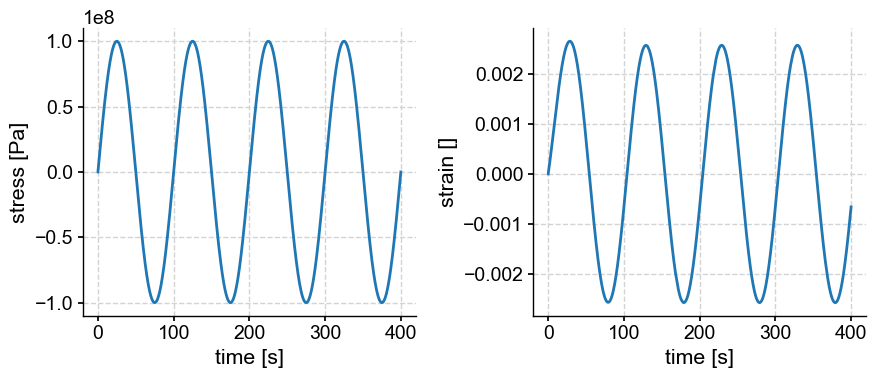

In [4]:
tmax = 100
dt_max = 1 / f_Hz / 50

strain_vals, stress_vals, t = calc_stress_strain(
    400, dt_max, stress, sls_solid, tmin=0.00000001, n_t=int(1e4)
)

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(9, 4))
axs[0].plot(t, stress_vals)
axs[0].set_xlabel("time [s]")
axs[0].set_ylabel("stress [Pa]")
axs[1].plot(t, strain_vals)
axs[1].set_xlabel("time [s]")
axs[1].set_ylabel("strain []")
plt.tight_layout()

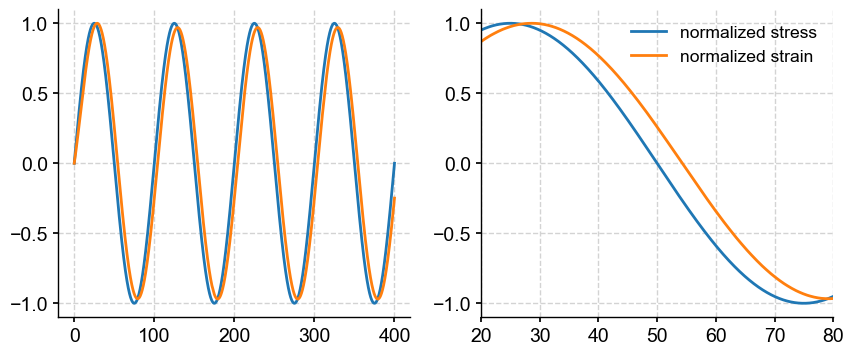

In [5]:
n_strain = strain_vals / strain_vals[t > 20].max()
n_stress = stress_vals / stress_vals.max()

f, axs = plt.subplots(ncols=2, nrows=1, figsize=(10, 4))
axs[0].plot(t, n_stress, label="normalized stress")
axs[0].plot(t, n_strain, label="normalized strain")

axs[1].plot(t, n_stress, label="normalized stress")
axs[1].plot(t, n_strain, label="normalized strain")

axs[1].set_xlim(20, 80)
axs[1].legend()

## loading the stress and strain curves as `pyleoclim` timeseries

Now we'll load up our stress and strain curves as `Series` objects (see [this tutorial for more info](https://linked.earth/PyleoTutorials/notebooks/L0_basic_MSES_manipulation.html)). 

In [6]:
stress_series = Series(
    t, stress_vals, time_unit="s", value_unit="Pa", value_name="stress"
)

Time axis values sorted in ascending order


In [7]:
strain_series = Series(
    t, strain_vals, time_unit="s", value_unit="", value_name="strain"
)

Time axis values sorted in ascending order


and combine them into a `MultipleSeries`

In [8]:
multi_series = MultipleSeries([stress_series, strain_series])

now that we have our two Series together, we can utilize some of the nice plot types that are typically used in paleoclimate analysis. 

First, a stack plot:

(<Figure size 640x480 with 3 Axes>,
 {0: <Axes: ylabel='stress [Pa]'>,
  1: <Axes: ylabel='strain []'>,
  'x_axis': <Axes: xlabel='time [s]'>})

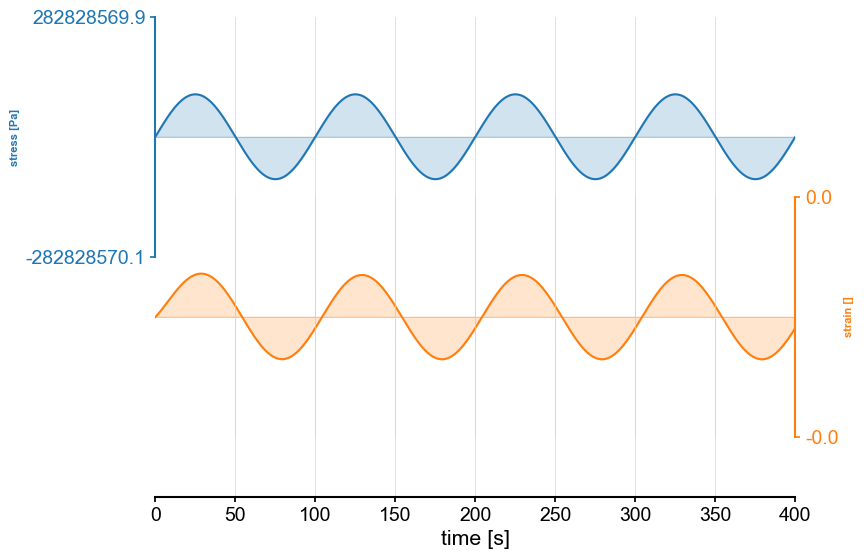

In [9]:
multi_series.stackplot()

From which the phase lag is apparent even without overlaying the curves. 

It's also fun to use "warming stripes", which plot the positive and negative devations from 0:

(<Figure size 640x480 with 2 Axes>, array([<Axes: >, <Axes: >], dtype=object))

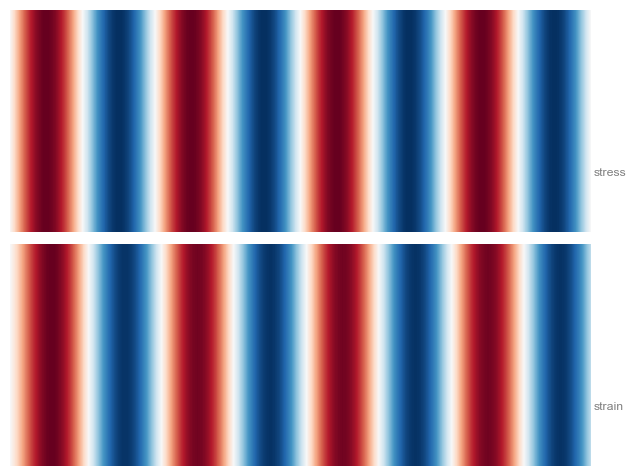

In [10]:
multi_series.stripes()

but what we really care about is calculating that phase lag. 

`pyleoclim` has a number of advanced time series analysis methods for comparing series. We'll use wavelet analysis here -- check out the [wavelet analysis tutorial](https://linked.earth/PyleoTutorials/notebooks/L2_wavelet_analysis.html) from `pyleoclim`, in particular the section on [wavelet coherence](https://linked.earth/PyleoTutorials/notebooks/L2_wavelet_analysis.html#wavelet-coherence) for more details. 

In our case, we want to calculate the wavelet coherence between the two series, which can be done with:

In [11]:
wc = stress_series.wavelet_coherence(strain_series)

we can plot up the result in a coherence plot

(<Figure size 1000x800 with 2 Axes>,
 <Axes: xlabel='Time [s]', ylabel='Scale [s]'>)

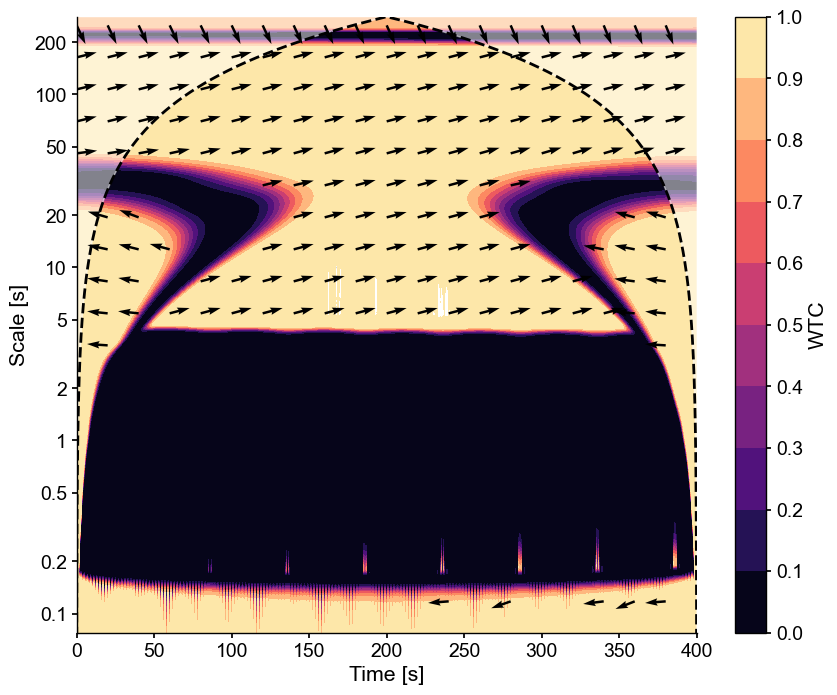

In [12]:
wc.plot()

So there's a lot of information in this plot. Let's break it down! 

First off, the x axis is just our timeseries time. The y axis is the wavelet time scale -- in a simplified sense you can think of it as a time windowing length. The contour values vary between 0 and 1: at 0, the values do not co-vary while at 1 values exactly co-vary. 

Our applied stress used a 100 second period (frequency of 0.01 Hz): so you can see at time scales close of that magnitude (say 50 to 150), the curves co-vary exactly for the whole experiment. At shorter time scales, things get messy: between 5-50 seconds, experimental times close to the edge behave a bit funny likely due to edge-effects of the anlysis. At values below about 5, there is no co-variation because we are calculating at time scales much smaller than is sensible for our analysis. 

The arrows on the plot represent phase lag. From the `pyleoclim` tutorial:

> the phase angle between the two series, using a trigonometric convention (right = 0, top = 90 degrees, left = 180 degrees, bottom = -90 or + 270 degrees).

So we see for the sensible time scales of interest (50-150), arrows all point to the top right, indicating the constant lag between our curves. 

We can pull out what theactual values are with the `phase_stats` attribute:

> the wavelet transform coherency (WTC), which may be thought of as a (squared) correlation coefficient in time-scale space: 0 if the series do not covary, 1 if they vary in perfect unison at that time and scale.
>
> the phase angle between the two series, using a trigonometric convention (right = 0, top = 90 degrees, left = 180 degrees, bottom = -90 or + 270 degrees).

In [13]:
phase_stats = wc.phase_stats(scales=[50, 150])
phase_stats

Results(mean_angle=0.24983093824071725, kappa=29477.46915245149, sigma=0.0058244991547985485, kappa_hi=30157.618773362374, sigma_lo=0.0057584430600770365)

Remebering that attenuation is defined as $tan(\delta)$ where $\delta$ is the lag (in radians), we can calulate attenuation with:

In [15]:
lag_angle_rad = phase_stats.mean_angle * np.pi / 180
attenuation = np.tan(lag_angle_rad)

attenuation, np.log10(attenuation)

(0.004360400080223272, -2.3604736610383243)

This analysis demonstrates the start to a full characterization of stress-strain analysis. To compute a full spectrum attenuation for the SLS, we could re-write all this to loop over frequency values for applied stress and vary all the attributes defining the SLS to map attenuation as a function of any parameter of interest. 

Furthermore, while `pyleoclim` is a bit over-powered for our needs in this notebook, if instead the stress-strain data came from a true deformation experiment then data would include additional complexities that could benefit from the rigorous time-series analysis accesible via `pyleoclim` to, for example: calculate attenuation directly from experimental data in time-domain or to test how well different deformation models capture complexity of real data. 